In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format = "-",
                start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)


In [3]:
def trend(time, slope = 0):
  return slope * time


def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2* np.pi),
                  1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude = 1, phase = 0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [4]:
time = np.arange(4 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [5]:
## Create the series
series = baseline + trend(time, slope) + \
         seasonality(time, period = 365,
                     amplitude = amplitude)

## Update with noise
series += noise(time, noise_level, seed = 42)

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1,
                           drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
dataset = windowed_dataset(x_train, window_size,
                           batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [9]:
L0 = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.models.Sequential([L0])

model.compile(loss = "mse",
              optimizer = tf.keras.optimizers.SGD(lr = 1e-6,
                                                  momentum = 0.9))
model.fit(dataset,
          epochs = 100,
          verbose = 0)

print("Layer weights {}".format(L0.get_weights()))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Layer weights [array([[ 0.01432117],
       [-0.08276789],
       [ 0.01001546],
       [ 0.05157873],
       [ 0.04235312],
       [-0.03182783],
       [ 0.0089256 ],
       [-0.00213602],
       [-0.03431964],
       [ 0.02811471],
       [-0.01977757],
       [ 0.04311888],
       [-0.07717686],
       [ 0.07910957],
       [-0.026911  ],
       [ 0.12223932],
       [-0.03577738],
       [ 0.1907051 ],
       [ 0.22679527],
       [ 0.49067125]], dtype=float32), array([0.01389367], dtype=float32)]


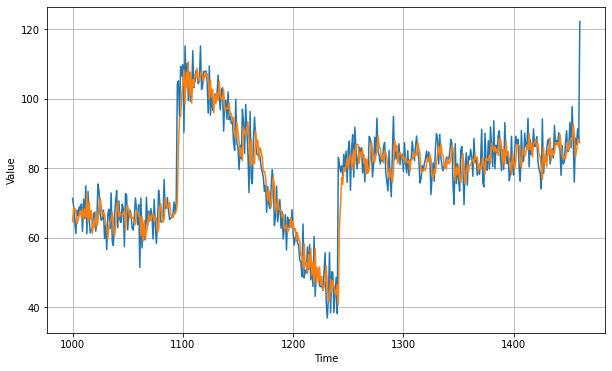

In [10]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
  
forecast = forecast[split_time - window_size : ]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0036607